# 🎾 EDA: Predicting Match Winners Based on Rankings

In this notebook, we explore ATP match data with the goal of understanding how player rankings influence match outcomes. Unlike our previous model, which only predicted whether the higher-ranked player won, this time we aim to build a model that predicts the **actual match winner**.

We'll load data from **2020 to 2023** (excluding 2024, which we'll reserve for backtesting) and explore:
 - How often the higher-ranked player wins
- How absolute rank gap affects predictability

 ## 📅 Load & Prepare Data
 We'll load raw ATP match data from 2020 to 2023 and clean it up to keep only relevant columns and valid matches with ranking information.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Years to include in EDA (2024 reserved for backtesting)
years = [2020, 2021, 2022, 2023]
dfs = []

for year in years:
    df = pd.read_csv(f"../../data/raw/atp_matches_{year}.csv")
    df = df[[
        "tourney_date", "surface", "winner_name", "loser_name",
        "winner_rank", "loser_rank"
    ]]
    df.dropna(subset=["winner_rank", "loser_rank"], inplace=True)
    df["winner_rank"] = df["winner_rank"].astype(int)
    df["loser_rank"] = df["loser_rank"].astype(int)
    df["year"] = year
    dfs.append(df)

# Combine all years
df_all = pd.concat(dfs, ignore_index=True)
df_all.reset_index(drop=True, inplace=True)

In [ ]:
## 🔎 Basic Overview
Let's look at the size and structure of the combined dataset.


In [4]:
df_all.info()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9956 entries, 0 to 9955
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tourney_date  9956 non-null   int64 
 1   surface       9920 non-null   object
 2   winner_name   9956 non-null   object
 3   loser_name    9956 non-null   object
 4   winner_rank   9956 non-null   int64 
 5   loser_rank    9956 non-null   int64 
 6   year          9956 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 544.6+ KB


,tourney_date,surface,winner_name,loser_name,winner_rank,loser_rank,year
0,20200106,Hard,Novak Djokovic,Rafael Nadal,2,1,2020
1,20200106,Hard,Roberto Bautista Agut,Dusan Lajovic,10,34,2020
2,20200106,Hard,Novak Djokovic,Daniil Medvedev,2,5,2020
3,20200106,Hard,Dusan Lajovic,Karen Khachanov,34,17,2020
4,20200106,Hard,Rafael Nadal,Alex De Minaur,1,18,2020


## 📊 How Often Does the Higher-Ranked Player Win?
 
We'll create a column `higher_ranked_won` that tracks whether the higher-ranked player won the match. This gives us a baseline for how predictive ranking is

In [5]:
df_all["higher_ranked_won"] = (df_all["winner_rank"] < df_all["loser_rank"]).astype(int)
win_rate = df_all["higher_ranked_won"].mean()
print(f"Higher-ranked player win rate: {win_rate:.2%}")

Higher-ranked player win rate: 63.93%


## 📌 Insight: Baseline Predictability

Over the 2020–2023 period, the higher-ranked player won **63.93%** of matches. This confirms that ATP rankings are meaningfully predictive — but not overwhelmingly so. Roughly 1 in 3 matches are "upsets" where the lower-ranked player wins, highlighting the potential for a predictive model to improve over simple heuristics.


## 🔹 Rank Difference Distribution
We'll examine how the difference in ranking between winner and loser is distributed. This helps us understand how many matches are between closely-ranked players vs mismatches.


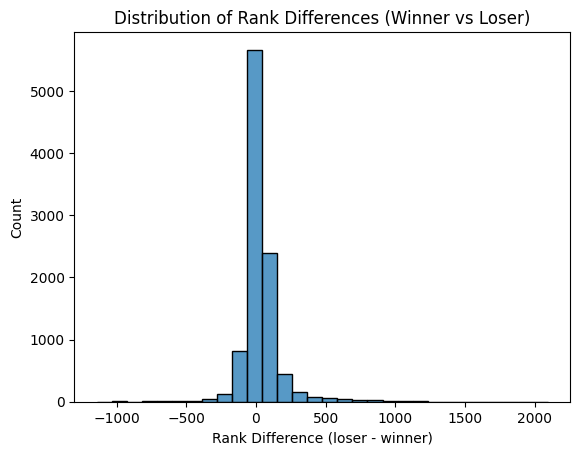

In [8]:
df_all["rank_diff"] = df_all["loser_rank"] - df_all["winner_rank"]
sns.histplot(df_all["rank_diff"], bins=30)
plt.title("Distribution of Rank Differences (Winner vs Loser)")
plt.xlabel("Rank Difference (loser - winner)")
plt.show()

### 📉 Interpretation: Rank Difference Distribution

This plot shows how often matches occur at different rank gaps.

- Most matches cluster tightly around a **small rank difference**, which makes sense — especially in later tournament rounds.
- There’s a clear right skew, meaning the **higher-ranked player usually wins**.
- But there are still plenty of matches with **negative values**, where lower-ranked players defeated stronger opponents — these are the upsets that make prediction interesting.

This also shows us that we need to model matches where the rank gap is small differently than when it's large — because those are closer to coin flips.

## 📊 Win Rate by Rank Gap
In this section, we're testing a key assumption: **Does a larger ranking gap make match outcomes more predictable?**

Rather than looking at the rank difference based on the match outcome (which would be circular), we calculate the **absolute rank gap** between the two players. This helps us evaluate how much the distance in skill level — as estimated by ATP rank — correlates with the higher-ranked player winning.

We bin these rank gaps into ranges (e.g., 0–10, 10–25, etc.) and compute the win rate of the higher-ranked player in each bin to identify trends.

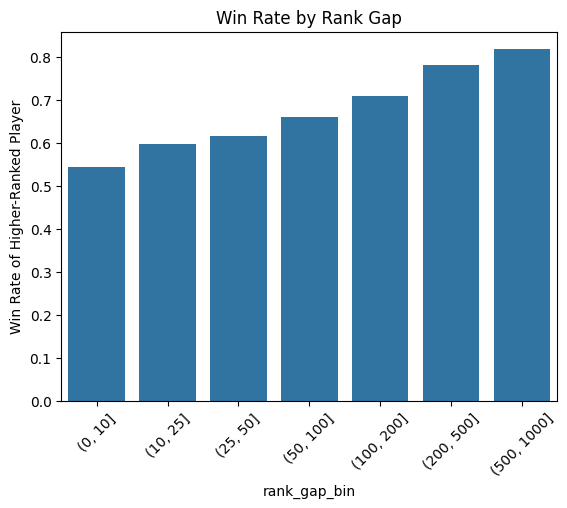

In [14]:
df_all["rank_gap"] = abs(df_all["winner_rank"] - df_all["loser_rank"])
gap_bins = [0, 10, 25, 50, 100, 200, 500, 1000]
df_all["rank_gap_bin"] = pd.cut(df_all["rank_gap"], bins=gap_bins)

win_by_gap = df_all.groupby("rank_gap_bin", observed=True)["higher_ranked_won"].mean().reset_index()

sns.barplot(data=win_by_gap, x="rank_gap_bin", y="higher_ranked_won")
plt.xticks(rotation=45)
plt.ylabel("Win Rate of Higher-Ranked Player")
plt.title("Win Rate by Rank Gap")
plt.show()

### 📈 Interpretation: Win Rate by Rank Gap


This plot validates our intuition: **the larger the rank gap, the more likely the higher-ranked player is to win**.

- When the rank gap is small (0–10), matches are roughly balanced — win rate is around 56%.
- As the gap increases, predictability increases. At a 200–500 rank gap, the higher-ranked player wins nearly 80% of the time.
- For massive mismatches (500+), win rate exceeds 80%.

This confirms that **absolute rank gap** is a strong signal — and a great candidate for a feature in our final prediction model.

This version of the plot avoids mixing up the outcome with the feature. It shows how predictive rank is:

- When players are ranked within 10 spots, matches are close to coin flips.
- As the gap widens (e.g., 50+ ranks apart), the higher-ranked player wins more consistently.

This supports the idea that **rank gap** is a meaningful predictive feature — especially when large.

### 📝 Summary: What We Learned

- **Higher-ranked players win ~64% of the time**, confirming that ATP rank has predictive power.
- **Rank difference distribution** shows that most matches occur between similarly ranked players — yet upsets still happen.
- **Absolute rank gap** is strongly correlated with win probability — bigger gaps lead to more predictable outcomes.


These findings shape our next steps: we'll design features that reflect **relative player strength**,  ensure our features reflect only information available **before the match is played**.
